In [2]:
#import some necessary librairies

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

from sklearn.pipeline import make_pipeline
from scipy import stats
from scipy.stats import norm, skew #for some statistics


pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points


from subprocess import check_output
print(check_output(['ls']).decode("utf8")) #check the files available in the directory

data_description.txt
pima-indians-diabetes.data.csv
sample_submission.csv
submission.csv
test.csv
TrabalhoHeraldo2018.ipynb
train.csv



## Importando arquivos
Alem do import, vamos deixar as informações do dataset expostas para consultas.

In [3]:
#Now let's import and put the train and test datasets in  pandas dataframe
desc  = open('./data_description.txt', 'r')
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
print(desc.read())

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

Removendo colunas de ID que não agregam informação alguma.

In [4]:
#check the numbers of samples and features
print("Shape do dataset de treino : {} ".format(train.shape))
print("Shape do dataset de teste : {} ".format(test.shape))

#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("\nShape do dataset de treino após remover o ID : {} ".format(train.shape)) 
print("Shape do dataset de teste após remover o id : {} ".format(test.shape))

Shape do dataset de treino : (1460, 81) 
Shape do dataset de teste : (1459, 80) 

Shape do dataset de treino após remover o ID : (1460, 80) 
Shape do dataset de teste após remover o id : (1459, 79) 


### Processamento de dados ( Eliminando colunas vaizas, dados irrelevantes, outliers etc.)

#### a.Visualização dos dados e tratamento de outliers extremos

O primeiro passo agora é visualizar a integridade dos nossos dados, e para isso vamos olhar como esta a distribuição dos valores das casas dado a área, que provavelmente é um dos principais parâmetros para se estimar o valor da mesma.

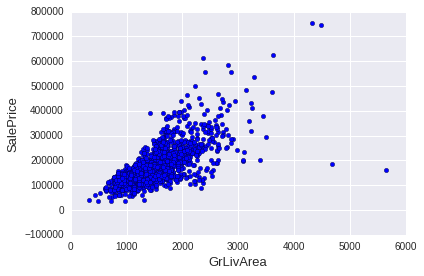

In [5]:
# Plot simples dos dados.
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

Podemos perceber que existem dados que se configuram como outliers, e como são muito poucos isso vai acabar interferindo negativamente no nosso estimador porque irá bagunçar a distribuição dos dados. Assim, nos vamos deletar esses dados que tem são completamente destoantes. Mesmo porque não faz muito sentido tão poucas casas com preço tão baixo e  tamanho tão grande.

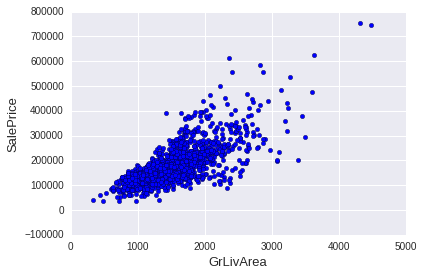

In [6]:
# Deletando outliers que podem prejudicar o modelo
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

# Avaliando grafico de preços por área
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

#### b.Caracterizando Features
Vamos tratar todos os nossos dados de treinamento, incluindo nossos dados de test.
E o primeiro passo será entender nossos dados. Ver como estão distribuidos, ver como estão organizados, ver o que está faltando etc.
Na célula abaixo vamos separar os targets (preços das casas) para melhor organização.

In [7]:
# Vamos tratar todos os nossos dados de uma vez só.
ntrain = train.shape[0]
ntest = test.shape[0]

y_train = train.SalePrice.values

all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("Tamanho total dos datasets : {}".format(all_data.shape))

Tamanho total dos datasets : (2917, 79)


Aqui nos vamos visualizar os dados que estão faltantes.
Como se pode ver existem parâmetros, tais quais PoolQC que é todo praticamente vazio.
Podemos remove -lo, mas fica como um trabalho futoro testar o modelo sem esse parâmetro.

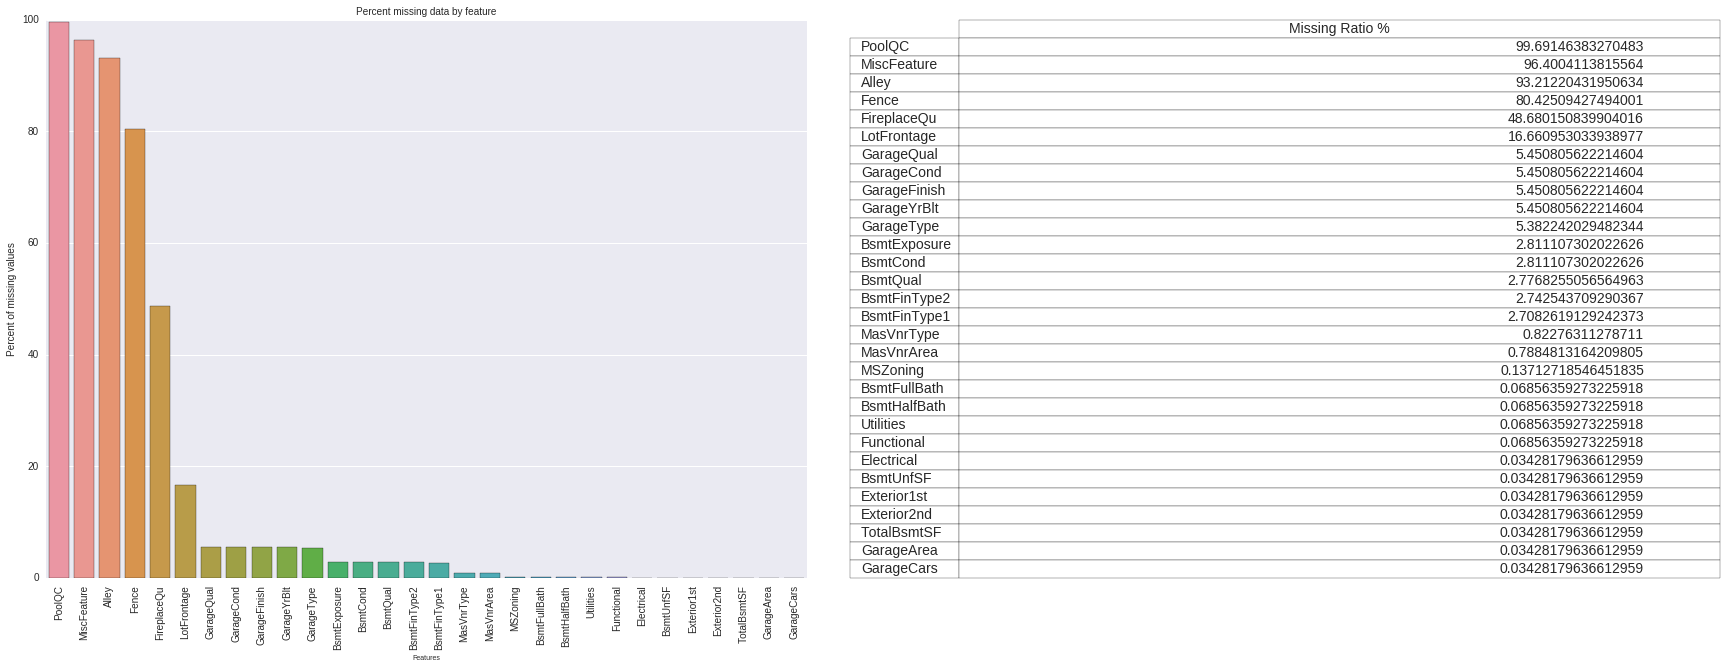

In [8]:
import matplotlib.pyplot as plt
from matplotlib import six
import pandas as pd
import numpy as np

all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio %' :all_data_na})
missing_data.head(5)

#f, ax = plt.subplots(figsize=(7, 5))
fig = plt.figure(figsize=(30,10))
ax1 = fig.add_subplot(121)
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=7)
plt.ylabel('Percent of missing values', fontsize=10)
plt.title('Percent missing data by feature', fontsize=10)

ax2 = fig.add_subplot(122)
font_size=14
bbox=[0, 0, 1, 1.0]
ax2.axis('off')

mpl_table = ax2.table(cellText = missing_data.values, rowLabels = missing_data.index, bbox=bbox, colLabels=missing_data.columns)
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(font_size)

##### Correlação
Alem da caracterização para com dados faltantes vamos ver como está a correlação dos nossos dados.
Sabemos que isso é apenas uma correlação um pra um, e que por isso não descreve todas as formas com as quais nossos dados estão conectados, mas é um bom indicativo inicial para entendermos o que está acontecendo.
Por exemplo: podemos ver que o ano de construção da garabem é muito correlacionado com o ano de construção da casa, justamente pq a casa e a garagem quase sempre são construidos juntos, então esse dado provavelmente não acrescenta em nada.
Podemos ver também quais são os dados que são muito correlacionados com o preço da casa, como por exemplo a qualidade do imóvel, tamanho da garagem, quantidade de carros permitidos na garagem etc.

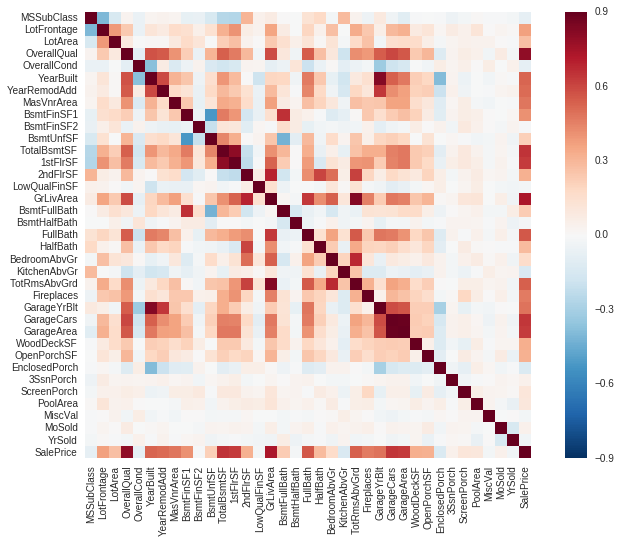

In [15]:
# Heatmap de correlação dos dados
corrmat = train.corr()
plt.subplots(figsize=(12,8))
sns.heatmap(corrmat, vmax=0.9, square=True)

#### c.Tratando dados faltantes.
Vamos começar o tratamento dos dados, mas é importante notar de início que existem coisas que não existem, e coisas que são zero. Por exemplo, quando a casa não tem garagem, isso significa que a garagem tem tamanho zero.
Os primeiros dados que vamos tratar são os dados que realmente não existem, como Cerca, Qualidade da piscina etc.

##### c1.Dados que são vazios de fato
Dados que quando faltam significa a AUSENCIA do parâmetro
Para trabalhos futuros, podemos tentar substituir por um valor como -1 para ver como o modelo reage a esse outlier.

In [16]:
for col in ('Alley', # Não tem acesso por Alley (Beco)
            'BsmtQual', # Não tem porão
            'BsmtCond', # Não tem porão
            'BsmtExposure', # Não tem porão
            'BsmtFinType1', # Não tem porão
            'BsmtFinType2', # Não tem porão
            'Fence', # Não tem cerca
            'FireplaceQu', # Não tem lareira
            'GarageType', # Não tem garagem
            'GarageFinish', # Não tem garagem
            'GarageQual', # Não tem garagem
            'GarageCond', # Não tem garagem
            'MasVnrType', # Não tem alvenaria
            'MiscFeature',  # Não tem miscelanious
            'MSSubClass', # A Casa não possui um tipo definido ??? Será que é apartamento ?            
            'PoolQC'): # Não tem piscina
    all_data[col] = all_data[col].fillna('None')

##### c2.Dados possuem valor zero.

Os dados abaixo são dados que quando estão faltantes significa que possuem falor ZERO.

In [17]:
for col in ('BsmtFinSF1', # Não possui porão então a área do mesmo é ZERO
            'BsmtFinSF2', # Não possui porão então a área do mesmo é ZERO
            'BsmtUnfSF', # Não possui porão então a área do mesmo é ZERO            
            'BsmtFullBath', # Não possui porão então a área do mesmo é ZERO
            'BsmtHalfBath', # Não possui porão então a área do mesmo é ZERO
            'GarageYrBlt', # Não possui garagem então a área do mesmo é ZERO
            'GarageArea', # Não possui garagem então a área do mesmo é ZERO
            'GarageCars', # Não possui garagem então a área do mesmo é ZERO
            'MasVnrArea', # Não possui alvenaria então a área do mesmo é ZERO
            'TotalBsmtSF'): # Não possui porão então a área do mesmo é ZERO
    all_data[col] = all_data[col].fillna(0)

##### c3.Dados que estão vazios por erro, mas são calculáveis a partir de outros

Esses dados apesar de estarem faltantes, podem ser calculados apartir de outros dados, ou serem preenchidos com a moda dos demais. Fazemos isso para tentar manter nosso modelo o mais robusto possível.
O LotFrontage por exemplo diz respeito ao tamanho da rua ligada a propriedade, logo
Podemos obter esse valor a partir dos vizinhos dessa pessoa. No caso fizemos a média deles. Isso apesar de parecer ser bobo, está reforçando ao nosso modelo que esse comportamento é esperado.
Os demais dados nós iremos preencher com a moda pois eu os julguei não muito importantes principalmente poque são poucos que estão faltando.

In [18]:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [19]:

for col in ('Electrical', 
            'MSZoning',
            'KitchenQual',
            'Exterior1st',
            'Exterior2nd',
            'SaleType'):
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

In [20]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

#### c4.Dados inúteis
Os dados de Utilities, eu optei por deletar pois, assim como muitos colegas no Kaggle, não vi nenhuma utilidade para o mesmo.

In [21]:
all_data = all_data.drop(['Utilities'], axis=1)

In [23]:
# Vendo se ainda existe dados faltantes 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


#### d.Feature engineering

Vamos começar os tratamentos dos dados. Aqui vamos preparar os dados que são categóricos dos dados que não são.
- Variáveis numerícas que são categóricas
- Variáveis categóricas que são numéricas

Por exemplo o MSSubClass, apesar de ser numérico, é categórico, pois os numeros que codificam essa coluna não possuem nenhuma correlação entre si, e isso pode prejudicar nosso estimador.

In [25]:
# MSSubClass é a classe do prédio
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

# Transformando em string variável categórica : Rates(0 - 10) the overall condition of the house
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

# Mes e ano também são transformados em string para serem tratados pelo hotEncoder
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [26]:
# Usando labelEncoder para cada uma das colunas abaixo
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape para vermos que nada mudou, só estamos preparando as variáveis categóricas.        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 78)


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


O dado de vizinhos pode ser codificado como uma variável numérica segundo : (https://ww2.amstat.org/publications/jse/v19n3/decock/AmesResidential.pdf) Aparamentemente como se fossem pesos para cada região. Então vamos fazer uso disso.

In [31]:
neighborhood_map = {'CollgCr': 98, 'Veenker': 98, 'Crawfor': 106, 'NoRidge': 101,
                    'Mitchel': 99, 'Somerst': 101, 'NWAmes': 99, 'OldTown': 102, 
                    'BrkSide': 106, 'Sawyer': 101, 'NridgHt': 104, 'NAmes': 100,
                    'SawyerW': 98, 'IDOTRR': 102, 'MeadowV': 90, 'Edwards': 98, 
                    'Timber': 103, 'Gilbert': 97, 'StoneBr': 104, 'ClearCr': 103, 
                    'NPkVill': 109, 'Blmngtn': 105, 'BrDale': 105, 'SWISU': 99 ,
                    'Blueste': 99}

def map_neighborhood(neighborhood):
    if isinstance(neighborhood, float) and np.isnan(neighborhood): return neighborhood
    return neighborhood_map[neighborhood]

all_data['Neighborhood'] = all_data['Neighborhood'].transform(map_neighborhood)\
                                                   .astype(float)

# Separando novamente os dados de treino e teste após serem tratados.
train = all_data[:ntrain]
test = all_data[ntrain:]

#### d1.Criando features.
Aqui foram criadas essas features a partir das análises feitas mais adiante, porém a grande maioria desses dados possuem uma relevância muito grande para o modelo, então tentei combina-los para tentar mostrar ao modelo que são dados muito relevântes.

In [27]:
# Adicionando informação do percentual do terreno usado para habitação
all_data['PercntLiv'] =  (all_data['GrLivArea']/all_data['LotArea'])*100

# Adicionando informação de área total da casa. Primeiro andar, Porão, e segundo andar.
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

all_data["TotalArea"] = all_data["TotalBsmtSF"] + all_data["1stFlrSF"] + all_data["2ndFlrSF"] + all_data["GarageArea"]
all_data["+_TotalHouse_OverallQual"] = all_data["TotalSF"] * all_data["OverallQual"]
all_data["+_GrLivArea_OverallQual"] = all_data["GrLivArea"] * all_data["OverallQual"]
all_data["+_BsmtFinSF1_OverallQual"] = all_data["BsmtFinSF1"] * all_data["OverallQual"]
all_data["-_LotArea_OverallQual"] = all_data["LotArea"] * all_data["OverallQual"]
all_data["-_TotalHouse_LotArea"] = all_data["TotalSF"] + all_data["LotArea"]
all_data["Bsmt"] = all_data["BsmtFinSF1"] + all_data["BsmtFinSF2"] + all_data["BsmtUnfSF"]
all_data["Rooms"] = all_data["FullBath"]+all_data["TotRmsAbvGrd"]
all_data["PorchArea"] = all_data["OpenPorchSF"]+all_data["EnclosedPorch"]+all_data["3SsnPorch"]+all_data["ScreenPorch"]
all_data["TotalPlace"] = all_data["TotalBsmtSF"] + all_data["1stFlrSF"] + all_data["2ndFlrSF"] + all_data["GarageArea"] + all_data["OpenPorchSF"]+all_data["EnclosedPorch"]+all_data["3SsnPorch"]+all_data["ScreenPorch"]
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 90)


#### e.Tratamento estatístico

Outro ponto importante no tratamento dos nossos dados é faze-los estarem de acordo com a normal, justamente porque nosso modelo é um estimador.

In [34]:
# Modificação dos preços normalizadas com o fator de escala do bairro.
# data_train['SalePrice'] = data_train['SalePrice']*100/data_train['Neighborhood']
# target = data_train['SalePrice']
# Optei por não fazer essa modificação pois queria estudar como isso impacta o modelo
# Vou deixar isso mais para o futuro.
target = y_train

Sabemos que preditores lineares tem distribuição linear, assim temos que ver como está a distribuição dos nossos dados e adapta-los para distribuição mais próxima da normal possível.

/home/igor-nasc/.local/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


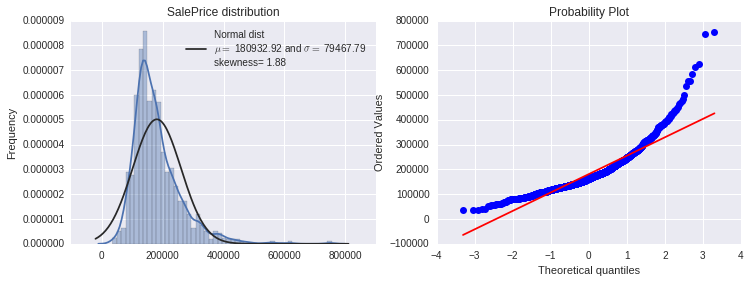

In [35]:
# # Sabemos que preditores lineares tem distribuição linear, assim
# # Temos que ver como está a distribuição dos nossos dados e adapta-los para distribuição mais próxima
# # Da normal possível
from scipy import stats
from scipy.stats import norm, skew

# Plotando a distribuição dos dados.
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.distplot(target, bins=50 ,fit = norm, ax = axes[0]);
(mu, sigma) = norm.fit(target)

# Legenda das distribuições
axes[0].legend(['Normal dist \n$\mu=$ {:.2f} and $\sigma=$ {:.2f} \nskewness= {:.2f}'
                                    .format(mu, sigma, skew(target))],
                loc='best')
axes[0].set_ylabel('Frequency')
axes[0].set_title('SalePrice distribution')

# QQ-plot
stats.probplot(target, plot = axes[1])
plt.show()

##### e1.Alinhando a distribuição dos dados

Usaremos a função log1p para alinhar a distribuição dos nossos targets para que o modelo tenha uma precisão melhor. <br>
Vamos adquirir o mu e sigma para a curva de distribuição. 

/home/igor-nasc/.local/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


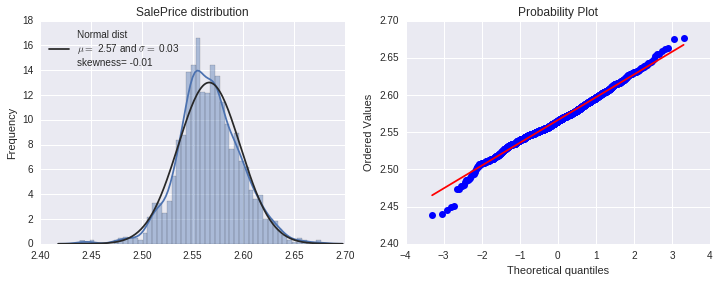

In [37]:
target = np.log1p(target)

# Visualizando a distribuição após melhoria na organização dos targets
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.distplot(target, bins=50 ,fit = norm, ax = axes[0]);

# Adquirindo o mu e sigma para a curva de distribuição
(mu, sigma) = norm.fit(target)
axes[0].legend(['Normal dist \n$\mu=$ {:.2f} and $\sigma=$ {:.2f}\nskewness= {:.2f}'
                                                .format(mu, sigma, skew(target))],
               loc='best')
axes[0].set_ylabel('Frequency')
axes[0].set_title('SalePrice distribution')

# QQ-plot
res = stats.probplot(target, plot = axes[1])
plt.show()

##### e2. Outros parâmetros que também não estão alinhados com a normal.

Além dos targets temos que organizar a distribuição dos outros parâmetros. <br>
Então primeiro vamos ver como está o skewness dos parâmetros.

In [40]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
-_TotalHouse_LotArea,12.173
LowQualFinSF,12.085
-_LotArea_OverallQual,11.682
3SsnPorch,11.372
LandSlope,4.973
KitchenAbvGr,4.301
BsmtFinSF2,4.145


##### e3.Tratando skewed features (Aplicando log + 1 em todas as que tem até 100% de desvio) 
Tratando parâmetros que possuem skewness muito alto.

In [41]:
skewness = skewness[abs(skewness) > 1]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)


There are 71 skewed numerical features to Box Cox transform


#### f.Tratando dados categóricos com get_dummies
Transformando dados categóricos em colunas linearmente independentes e separando os dados novamente.

In [44]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

# Separando novamente os dados de treino e teste após serem tratados.
train = all_data[:ntrain]
test = all_data[ntrain:]

(2917, 207)


##### f1.Avaliando parâmetros relevantes

Aqui nós iremos avaliar os parâmetros e suas relevancias para o estimador.

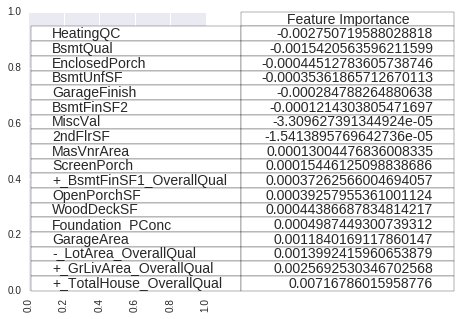

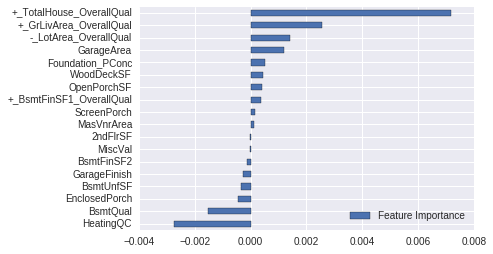

In [108]:
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

train2 = all_data[:ntrain]

lasso=Lasso(alpha=0.001)
lasso.fit(train2,target)
FI_lasso = pd.DataFrame({"Feature Importance":lasso.coef_}, index=train2.columns)
FI_lasso = FI_lasso.sort_values("Feature Importance",ascending=False)
org = FI_lasso[FI_lasso["Feature Importance"]!=0].sort_values("Feature Importance")

fig = plt.figure(figsize=(7,5))
ax1 = fig.add_subplot(121)
plt.xticks(rotation='90')
org.plot(kind="barh")

ax2 = fig.add_subplot(122)
font_size=14
bbox=[0, 0, 1.2, 1.0]
ax2.axis('off')

mpl_table = ax2.table(cellText = org[0:20].values, rowLabels = org[0:20].index, bbox=bbox, colLabels=org[0:20].columns)
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(font_size)



### Aplicando modelos

Aqui nós iremos aplicar os diferentes modelos para nosso estimador.

In [109]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import make_scorer
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.metrics import r2_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb

# Função para plot de histogramas 
def plot_hist_values_x_predictions(values, predictions):
    %pylab inline
    pylab.rcParams['figure.figsize'] = (10, 7)
    plt.hist([values, predictions], label=['Sale Price', 'Prediction'], bins=50)
    plt.legend(loc='upper right')
    plt.figure(figsize=(10,7))
    plt.show()
    
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, target, scoring="neg_mean_squared_error", cv = kf))
    return(rmse.mean())    
    
# R2 Score e RSME value combined
def lets_try(train,labels):
    results={}
    def test_model(clf):
        
        cv = KFold(n_splits=5,shuffle=True,random_state=45)
        r2 = make_scorer(r2_score)
        r2_val_score = cross_val_score(clf, train, labels, cv=cv,scoring=r2)
        scores=[r2_val_score.mean()]
        return scores
    
    #Validation function
    n_folds = 5
    def rmsle_cv(model):
        kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
        rmse= np.sqrt(-cross_val_score(model, train.values, target, scoring="neg_mean_squared_error", cv = kf))
        return(rmse.mean())
    
    results_rmsle={}
    
    clf = linear_model.LinearRegression()
    results["Linear"]=test_model(clf)
    results_rmsle["Linear"] = rmsle_cv(clf)
    
    clf = linear_model.Ridge()
    results["Ridge"]=test_model(clf)
    results_rmsle["Ridge"] = rmsle_cv(clf)
    
    clf = linear_model.BayesianRidge()
    results["Bayesian Ridge"]=test_model(clf)
    results_rmsle["Bayesian Ridge"] = rmsle_cv(clf)
    
    
    clf = linear_model.HuberRegressor()
    results["Hubber"]=test_model(clf)
    results_rmsle["Hubber"] = rmsle_cv(clf)
    
    
    clf = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
    results["ElasticNet"]=test_model(clf)
    results_rmsle["ElasticNet"] = rmsle_cv(clf)
    
    
    clf = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
    results["KernelRidgeRegressor"]=test_model(clf)
    results_rmsle["KernelRidgeRegressor"] = rmsle_cv(clf)
    
    
    clf = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
    results["GradientBoosting"]=test_model(clf)
    results_rmsle["GradientBoosting"] = rmsle_cv(clf)
    
    
    clf = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
    results["XGBoost"]=test_model(clf)
    results_rmsle["XGBoost"] = rmsle_cv(clf)
    
    
    clf = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
    results["LightGBM"]=test_model(clf)
    results_rmsle["LightGBM"] = rmsle_cv(clf)
    
    
    clf = linear_model.Lasso(alpha=1e-4)
    results["Lasso"]=test_model(clf)
    results_rmsle["Lasso"] = rmsle_cv(clf)
    
    
    clf = BaggingRegressor()
    results["Bagging"]=test_model(clf)
    results_rmsle["Bagging"] = rmsle_cv(clf)
    
    
    clf = RandomForestRegressor()
    results["RandomForest"]=test_model(clf)
    results_rmsle["RandomForest"] = rmsle_cv(clf)
    
    
    clf = AdaBoostRegressor()
    results["AdaBoost"]=test_model(clf)
    results_rmsle["AdaBoost"] = rmsle_cv(clf)
    
    
    clf = svm.SVR()
    results["SVM RBF"]=test_model(clf)
    results_rmsle["SVM RBF"] = rmsle_cv(clf)
    
    
    clf = svm.SVR(kernel="linear")
    results["SVM Linear"]=test_model(clf)
    results_rmsle["SVM Linear"] = rmsle_cv(clf)
    
    
    results = pd.DataFrame.from_dict(results,orient='index')
    results.columns=["R2 Score"]
    results=results.sort_values(["R2 Score"],ascending=False)
    
    results_rmsle = pd.DataFrame.from_dict(results_rmsle,orient='index')
    results_rmsle.columns=["RMSE"]
    results_rmsle=results_rmsle.sort_values(["RMSE"],ascending=False)
    
    result = pd.concat([results, results_rmsle], axis=1, join='inner')
    
    results.plot(kind="bar",title="Model Scores")    
    axes = plt.gca()
    axes.set_ylim([0.5,1])
    
    return result


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


,R2 Score,RMSE
ElasticNet,0.920,0.112
GradientBoosting,0.916,0.115
XGBoost,0.915,0.115
Bayesian Ridge,0.914,0.118
LightGBM,0.913,0.116
Lasso,0.913,0.117
KernelRidgeRegressor,0.911,0.119
Ridge,0.911,0.120
Hubber,0.906,0.124
SVM Linear,0.905,0.123


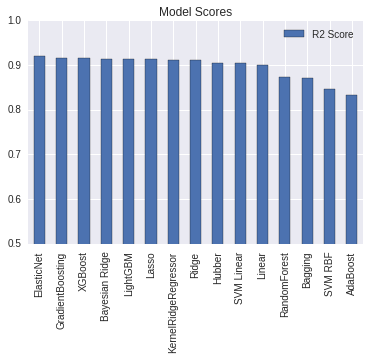

In [37]:
lets_try(train,target)

##### Estudo de modelos com PCA

Tentativa de redução de dimensionalidade com PCA para melhoria no estimador, mas aparentemente não funcionou muito bem. Então não usei os dados tratados com PCA para o modelo.

In [111]:
# O PCA é muito sensível a dados não 'normalizados'
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler, StandardScaler
scaler = StandardScaler()
train_scale = scaler.fit(train).transform(train)

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [112]:
pca = PCA(whiten=True)
pca.fit(train_scale)
variance = pd.DataFrame(pca.explained_variance_ratio_)
varRatioCum = np.cumsum(pca.explained_variance_ratio_)
i = 0
for elemt in varRatioCum:
    if elemt < 1:
        i +=1
print("Total de colunas que conseguem abstrair os dados:",i)

Total de colunas que conseguem abstrair completamente os dados: 185


Ou seja os 185 primeiros já possuem uma representação de 0.999999% dos dados, assim:

In [113]:
pca = PCA(n_components=200,whiten=True)
pca = pca.fit(train)
dataPCA = pca.transform(train)
dfPCA = pd.DataFrame(dataPCA)
dataPCA.shape

(1458, 200)

,R2 Score,RMSE
Lasso,0.906,0.009
ElasticNet,0.887,0.010
KernelRidgeRegressor,0.884,0.011
Bayesian Ridge,0.881,0.011
LightGBM,0.879,0.011
Ridge,0.877,0.011
GradientBoosting,0.846,0.012
RandomForest,0.800,0.013
Bagging,0.796,0.014
AdaBoost,0.780,0.015


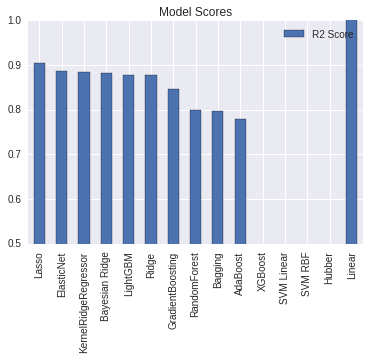

In [114]:
#Testando modelos com redução de dimensionalidade de PCA.
lets_try(dfPCA,target)

## Stacking Models

Essa é uma tecnica muito comum, aonde o objetivo é empilhar os modelos de forma a usar a predição de todos simultaneamente para chegar a um novo modelo que é a combinação de todos.<br>
Isso pode ser feito usando a média (AveragingModels) ou  StackingAveragedModels na qual ele usa um modelo pra selecionar os outros modelos, em resumo, e assim fazer a média dos melhores preditores.

#### Models

In [115]:
labels = pd.DataFrame(target)

In [116]:
#Validation function
n_folds = 5

x_scaler = RobustScaler()
y_scaler = RobustScaler()

x = x_scaler.fit_transform(train)
y = y_scaler.fit_transform(labels.values.reshape(-1, 1))

In [117]:
regr = linear_model.LinearRegression()
regBay = linear_model.BayesianRidge()
ridge = linear_model.Ridge()
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                  max_depth=4, max_features='sqrt',
                                  min_samples_leaf=15, min_samples_split=10, 
                                  loss='huber', random_state =5)

model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                            learning_rate=0.05, max_depth=3, 
                            min_child_weight=1.7817, n_estimators=2200,
                            reg_alpha=0.4640, reg_lambda=0.8571,
                            subsample=0.5213, silent=1,
                            random_state =7, nthread = -1)

model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))



In [122]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [123]:
averaged_models = AveragingModels(models = (ENet, regBay, GBoost, lasso, KRR, ridge ))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.0088 (0.0000)



In [124]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [ ]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, regBay, KRR),
                                                 meta_model = Lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

In [49]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [50]:
stacked_averaged_models.fit(train.values, target)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(target, stacked_train_pred))

0.07736288398480741


In [51]:
model_xgb.fit(train, target)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

197604.25689736163


In [52]:
model_lgb.fit(train, target)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

197604.254627903


In [53]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(target,stacked_train_pred*0.70 +
               xgb_train_pred*0.1 + lgb_train_pred*0.2 ))

RMSLE score on train data:
0.07350249600562024


In [54]:
# Montar uma rede neural pra escolher os melhores pesos entre os modelos.

In [55]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras import backend as K

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [89]:
class Ensemble():
    def __init__(self, models):
        K.clear_session()
        self.models = models
        
        self.ensemble_model = Sequential()
        #[Dense(1, activation = 'linear',input_dim = len(models))]
        
        #self.ensemble_model.add(Dense(12, input_dim=8, activation='linear'))
        self.ensemble_model.add(Dense(12, activation = 'relu',input_dim = len(models)))
        self.ensemble_model.add(Dense(8, activation='relu'))
        self.ensemble_model.add(Dense(1, activation='linear'))

        self.ensemble_model.compile(optimizer='sgd', loss='mse')      
        self.early_stopping = EarlyStopping(monitor='val_loss', patience=10)
        self.x_scaler = RobustScaler()
        self.y_scaler = RobustScaler()
        
    def fit(self, x, y):
        x = self.x_scaler.fit_transform(x.values)
        y = self.y_scaler.fit_transform(y.values.reshape(-1, 1))
        predictions = []
        i = 0
        for split in KFold(len(self.models), shuffle=True).split(x):
            self.models[i].fit(x[split[0]], y[:, 0][split[0]])
            predictions.append(self.models[i].predict(x))
            i += 1
        predictions_reshape = [[]]*len(x)
        for i in range(len(x)):
            aux = [];
            for j in range(len(predictions)):
                aux.append(predictions[j][i])
            predictions_reshape[i] = aux
        predictions_reshape = np.array(predictions_reshape)

        history = self.ensemble_model.fit(predictions_reshape, y[:, 0], epochs = 1000, 
                                          validation_split = 0.25, verbose = 0, 
                                          callbacks = [self.early_stopping])
        plt.plot(history.history['loss'], label = 'Train')
        plt.plot(history.history['val_loss'], label = 'Validation')
        plt.ylim(0.95*min(min(history.history['loss']), min(history.history['val_loss'])), 
                 1.1*max(history.history['val_loss']))
        plt.legend()
        plt.show()
    
    def predict(self, x):
        x = self.x_scaler.transform(x.values)
        predictions = []
        for i in range(len(self.models)):
            predictions.append(self.models[i].predict(x))
        predictions_reshape = [[]]*len(x)
        for i in range(len(x)):
            aux = [];
            for j in range(len(predictions)):
                aux.append(predictions[j][i])
            predictions_reshape[i] = aux
        predictions_reshape = np.array(predictions_reshape)
        
        return y_scaler.inverse_transform(self.ensemble_model.predict(predictions_reshape))\
                       .reshape(1, -1)[0]

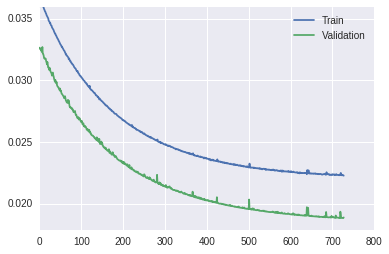

Error: 0.07310408310917667


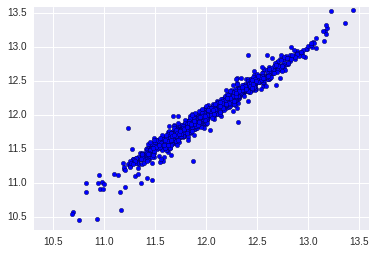

In [94]:
# ElasticNet 	0.920 	0.112
# GradientBoosting 	0.916 	0.115
# XGBoost 	0.915 	0.115
# Bayesian Ridge 	0.914 	0.118
# LightGBM 	0.913 	0.116
# Lasso 	0.913 	0.117

models = [
    StackingAveragedModels(base_models = (lasso, regBay, GBoost, KRR),
                                                 meta_model = ENet),
    Lasso(alpha =0.0005),
    ElasticNet(alpha=0.0005, l1_ratio=.9),
    lgb.LGBMRegressor(objective='regression',num_leaves=5,
                      learning_rate=0.05, n_estimators=720,
                      max_bin = 55, bagging_fraction = 0.8,
                      bagging_freq = 5, feature_fraction = 0.2319,
                      feature_fraction_seed=9, bagging_seed=9,
                      min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
    
]

ensemble = Ensemble(models)
ensemble.fit(train, labels)
predictions = ensemble.predict(train)

plt.scatter(predictions, target)
plt.xlim(min(min(predictions), min(labels.min())) - 0.15, 
         max(max(predictions), max(labels.min())) + 0.15)
plt.ylim(min(min(predictions), min(labels.min())) - 0.15, 
         max(max(predictions), max(labels.min())) + 0.15)
print('Error: ' + str(np.sqrt(mean_squared_error(predictions, labels))))

In [95]:
model = ensemble

submission = pd.DataFrame()
submission['Id'] = test_ID

predictions = model.predict(test)
final_predictions = np.expm1(predictions)

submission['SalePrice'] = final_predictions

submission.to_csv('submission.csv', index=False)

In [96]:
submission.shape

(1459, 2)

In [99]:
ensemble = stacked_pred*0.85 + xgb_pred*0.01 + lgb_pred*0.01

In [101]:
ensemble = stacked_pred

In [102]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)